In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
import time
import os
from huggingface_hub import InferenceClient
import re
from itertools import compress

df = pd.read_csv("data/mtsamples.csv")

## EDA

print(list(dict.fromkeys(df['medical_specialty'] )))
print(df.columns)
print(df.shape) #for number of rows
print(df['medical_specialty'].value_counts().size) #for number of medical specialties
print(df.isnull().sum()) 
df['medical_specialty'].value_counts().plot.hist(title="Number of Observations per Medical Specialty",xlabel = "Number of Observations",ylabel="Number of Medical Specialties")


## Shrink Original Dataset

In [2]:
random_subset = df.sample(n=200,random_state= 42)
print(random_subset.shape) #for number of rows
# print(random_subset['medical_specialty'].value_counts())

#remove observations associated to a medical state that only occurs <= 2 times
# list of specialties to remove
med_spec_g_two = random_subset['medical_specialty'].value_counts()[list(random_subset['medical_specialty'].value_counts() > 2)]
# print(med_spec_g_two)
# remove rows whose medical_specialty is in the list
df_filtered = random_subset[random_subset["medical_specialty"].isin(list(med_spec_g_two.keys()))]
###
# Also, generate list of possible specialties that survived
###
possible_specialties = list(df_filtered["medical_specialty"].value_counts().keys())
possible_specialties_no_whitespace = [re.sub(r"\s+", "", s).upper() for s in possible_specialties] # note all uppercase as well
# print(possible_specialties_no_whitespace)
# print(df_filtered)

(200, 6)


In [3]:
#we see some NA values remain
df_filtered.isna().sum()

Unnamed: 0            0
description           0
medical_specialty     0
sample_name           0
transcription         1
keywords             29
dtype: int64

## Prepping for LLM

In [3]:
#perform test-train split
df_filtered = df_filtered.rename(columns={'Unnamed: 0':'rowind'})
X = df_filtered.drop('medical_specialty',axis=1)
y = df_filtered['medical_specialty']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify = y)

In [5]:
#save training data to a csv for independently done Likert Scale questionnaire generation
#df_training_recovered = X_train.copy()
#df_training_recovered['medical_specialty'] = y_train.copy()
#df_training_recovered.to_csv("C:/Users/rhals/Documents/obsidian/scratch/20250913 Resume/ML Project/data/training_only.csv", index=False)

In [4]:
#map a dataframe row to a string formatted how the LLM prompt expects
def map_to_llm_friendly(data_row):
    description = str(data_row.iloc[1])
    title = str(data_row.iloc[2])
    transcription = str(data_row.iloc[3])
    keywords = str(data_row.iloc[4])
    to_return = "description:{"+description+"} title: {"+title + "} transcription:{"+transcription+ "} keywords:{" + keywords + "}"
    return(to_return)
# print(map_to_llm_friendly(X_train.iloc[2]))
# print(y_train.iloc[2])

In [7]:
#initialize
testing_results_1 = list()
training_results_1 = list()
prompt_prefix_classifier_with_uncertainty = "You are a medical expert asked to guess the medical specialty most relevant to a medical transcript. You are stating this guess to a panel of other medical experts from all specialties. Provide your best guess to the one medical specialty associated with this medical transcript and the probability that the classification is correct or plausible (0.0 to 1.0) for the following medical transcript. The possible classifications are: [' Surgery', ' Consult - History and Phy.', ' Cardiovascular / Pulmonary', ' Orthopedic', ' General Medicine', ' Urology', ' Radiology', ' Obstetrics / Gynecology', ' Neurology', ' SOAP / Chart / Progress Notes', ' Neurosurgery', ' Gastroenterology', ' Ophthalmology', ' Nephrology', ' Office Notes', ' ENT - Otolaryngology']. The medical transcript is written by a doctor and contains a short description beginning with ‘description:’, a title beginning with ‘title:’ , the actual transcription beginning with ‘transcription:’, and keywords they associate with that interaction beginning with ‘keywords:’. All sections are enclosed in curly brackets. Take your uncertainty in the prompt, the task difficulty, your knowledge availability and other sources of uncertainty into account. Give ONLY the guessed medical specialty and probability, no other words or explanation. Your response should begin with “<think>\n”. For example: “‘ <think>\n Guess: <most likely guess, as short as possible; not a complete sentence, just the guess!> Probability: <the probability between 0.0 and 1.0 that your guess is correct, without any extra commentary whatsoever; just the probability!> “‘ If you cannot provide an answer, answer with ‘NO ANSWER‘. Here are three examples: description:{ Left-sided large hemicraniectomy for traumatic brain injury and increased intracranial pressure.  She came in with severe traumatic brain injury and severe multiple fractures of the right side of the skull. } title: { Hemicraniectomy } transcription:{TITLE OF OPERATION:,  Left-sided large hemicraniectomy for traumatic brain injury and increased intracranial pressure.,INDICATION FOR SURGERY: ,  The patient is a patient well known to my service.  She came in with severe traumatic brain injury and severe multiple fractures of the right side of the skull.  I took her to the operating a few days ago for a large right-sided hemicraniectomy to save her life.  I spoke with the family, the mom, especially about the risks, benefits, and alternatives of this procedure, most especially given the fact that she had undergone a very severe traumatic brain injury with a very poor GCS of 3 in some brainstem reflexes.  I discussed with them that this was a life-saving procedure and the family agreed to proceed with surgery as a level 1.  We went to the operating room at that time and we did a very large right-sided hemicraniectomy.  The patient was put in the intensive care unit.  We had placed also at that time a left-sided intracranial pressure monitor both which we took out a few days ago.  Over the last few days, the patient began to slowly deteriorate little bit on her clinical examination, that is, she was at first localizing briskly with the right side and that began to be less brisk.  We obtained a CT scan at this point, and we noted that she had a fair amount of swelling in the left hemisphere with about 1.5 cm of midline shift.  At this point, once again I discussed with the family the possibility of trying to save her life and go ahead and doing a left-sided very large hemicraniectomy with this __________  this was once again a life-saving procedure and we proceeded with the consent of mom to go ahead and do a level 1 hemicraniectomy of the left side.,PROCEDURE IN DETAIL: , The patient was taken to the operating room.  She was already intubated and under general anesthesia.  The head was put in a 3-pin Mayfield headholder with one pin in the forehead and two pins in the back to be able to put the patient with the right-hand side down and the left-hand side up since on the right-hand side, she did not have a bone flap which complicated matters a little bit, so we had to use a 3-pin Mayfield headholder.  The patient tolerated this well.  We sterilely prepped everything and we actually had already done a midline incision prior to this for the prior surgery, so we incorporated this incision into the new incision, and to be able to open the skin on the left side, we did a T-shaped incision with T vertical portion coming from anterior to the ear from the zygoma up towards the vertex of the skull towards the midline of the skin.  We connected this.  Prior to this, we brought in all surgical instrumentation under sterile and standard conditions.  We opened the skin as in opening a book and then we also did a myocutaneous flap.  We brought in the muscle with it.  We had a very good exposure of the skull.  We identified all the important landmarks including the zygoma inferiorly, the superior sagittal suture as well as posteriorly and anteriorly.  We had very good landmarks, so we went ahead and did one bur hole and the middle puncta right above the zygoma and then brought in the craniotome and did a very large bone flap that measured about 7 x 9 cm roughly, a very large decompression of the left side.  At this point, we opened the dura and the dura as soon as it was opened, there was a small subdural hematoma under a fair amount of pressure and cleaned this very nicely irrigated completely the brain and had a few contusions over the operculum as well as posteriorly.  All this was irrigated thoroughly.  Once we made sure we had absolutely great hemostasis without any complications, we went ahead and irrigated once again and we had controlled the meddle meningeal as well as the superior temporal artery very nicely.  We had absolutely good hemostasis.  We put a piece of Gelfoam over the brain.  We had opened the dura in a cruciate fashion, and the brain clearly bulging out despite of the fact that it was in the dependent position.  I went ahead and  irrigated everything thoroughly putting a piece of DuraGen as well as a piece of Gelfoam with very good hemostasis and proceeded to close the skin with running nylon in place.  This running nylon we put in place in order not to put any absorbables, although I put a few 0 popoffs just to approximate the skin nicely.  Once we had done this, irrigated thoroughly once again the skin.  We cleaned up everything and then we took the patient off __________ anesthesia and took the patient back to the intensive care unit.  The EBL was about 200 cubic centimeters.  Her hematocrit went down to about 21 and I ordered the patient to receive one unit of blood intraoperatively which they began to work on as we began to continue to do the work and the sponges and the needle counts were correct.  No complications.  The patient went back to the intensive care unit.} keywords:{surgery, large hemicraniectomy, intracranial pressure, multiple fractures, skull, traumatic brain injury, mayfield headholder, injury, hemicraniectomyNOTE} Guess: Surgery Probability: 0.80 2) description:{ Port insertion through the right subclavian vein percutaneously under radiological guidance.  Metastatic carcinoma of the bladder and bowel obstruction.} title: { Port Insertion } transcription:{PREOPERATIVE DIAGNOSES,1.  Metastatic carcinoma of the bladder.,2.  Bowel obstruction.,POSTOPERATIVE DIAGNOSES,1.  Metastatic carcinoma of the bladder.,2.  Bowel obstruction.,PROCEDURE: , Port insertion through the right subclavian vein percutaneously under radiological guidance.,PROCEDURE DETAIL:  ,The patient was electively taken to the operating room after obtaining an informed consent.  A time-out process was followed.  Antibiotics were given.  Then, the patient's right deltopectoral area was prepped and draped in the usual fashion.  Xylocaine 1% was infiltrated.  The right subclavian vein was percutaneously cannulated without any difficulty.  Then using the Seldinger technique, the catheter part of the port, which was a single-lumen port, was passed through the introducer under x-ray guidance and placed in the junction of the superior vena cava and the right atrium.,A pocket had been fashioned and a single-lumen drum of the port was connected to the catheter, which had been trimmed and affixed to the pectoralis fascia with couple of sutures of Vicryl.  Then, the fascia was closed using subcuticular suture of Monocryl.  The drum was aspirated and irrigated with heparinized saline and then was put in the pocket and the skin was closed.  A dressing was applied including the needle and the port with the catheter so that the floor could use the catheter right away.,The patient tolerated the procedure well and was sent to recovery room in satisfactory condition.  A chest x-ray was performed that showed that there were no complications of procedure and that the catheter was in right place.} keywords:{surgery, metastatic carcinoma of the bladder, percutaneously, subclavian vein, port insertion, metastatic carcinoma, bowel obstruction, catheter} Guess: Surgery Probability: 0.79 3) description:{ A male patient presented for evaluation of chronic abdominal pain.} title: { Gen Med Consult - 34 } transcription:{Chief Complaint:, Chronic abdominal pain.,History of Present Illness:, 23-year-old Hispanic male who presented for evaluation of chronic abdominal pain. Patient described the pain as dull, achy, constant and located at the epigastric area with some radiation to the back. There are also occasional episodes of stabbing epigastric pain unrelated to meals lasting only minutes. Patient noted that the pain started approximately six months prior to this presentation. He self medicated “with over the counter“ antacids and obtained some relief so he did not seek medical attention at that time.,Two months prior to current presentation, he had worsening of his pain as well as occasional nausea and vomiting. At this time the patient was found to be H. pylori positive by serology and was treated with triple therapy for two weeks and continued on omeprazole without relief of his pain.,The patient felt he had experienced a twenty-pound weight loss since his symptoms began but he also admitted to poor appetite. He stated that he had two to three loose bowel movements a day but denied melena or bright red blood per rectum. Patient denied NSAID use, ethanol abuse or hematemesis. Position did not affect the quality of the pain. Patient denied fever or flushing. He stated he was a very active and healthy individual prior to these recent problems.,Past Medical History:, No significant past medical history.,Past Surgical History:, No prior surgeries.,Allergies:, No known drug allergies.,Medications:, Omeprazole 40 mg once a day. Denies herbal medications.,Family History:, Mother, father and siblings were alive and well.,Social History:, He is employed as a United States Marine officer, artillery repair specialist. He was a social drinker in the past but quit altogether two years ago. He never used tobacco products or illicit/intravenous drugs.,Physical Examination:, The patient was a thin male in no apparent distress. His oral temperature was 98.2 Fahrenheit, blood pressure was 114/67 mmHg, pulse rate of 91 beats per minute and regular, respiratory rate was 14 and his pulse oximetry on room air was 98%. Patient was 52 kg in weight and 173 cm height.,SKIN: No skin rashes, lesions or jaundice. He had one tattoo on each upper arm.,HEENT: Head was normocephalic and atraumatic. Pupils were equal, round and reactive. Anicteric sclerae. Tympanic membranes had a normal appearance. Normal funduscopic examination. Oral mucosa was moist and pink. Oral/pharynx was clear.,NECK: No lymphadenopathy. No carotid bruits. Trachea midline. Thyroid non-palpable. No jugular venous distension.,CHEST: Lungs were clear bilaterally with good air movement.,HEART: Regular rate and rhythm. Normal S1 and S2 with no murmurs, gallops or rubs. PMI was non-displaced.,ABDOMEN: Abdomen was flat. Normal active bowel sounds. Liver span percussed sixteen centimeters, six centimeters below R costal margin with irregular border that was mildly tender to palpation. Slightly tender to palpation in epigastric area. There was no splenomegaly. No abdominal masses were appreciated. No CVA tenderness was noted.,RECTAL: No perirectal lesions were found. Normal sphincter tone and no rectal masses. Prostate size was normal without nodules. Guaiac positive.,GENITALIA: Testes descended bilaterally, no penile lesions or discharge.,EXTREMITIES: No clubbing, cyanosis, or edema. No peripheral lymphadenopathy was noted.,NEUROLOGIC: Alert and oriented times three. Cranial nerves II to XII appeared intact. No muscle weakness or sensory deficits. DTRs equal and normal.,Radiology/Studies: 2 view CXR: Mild elevation right diaphragm.,CT of abdomen and pelvis: Too numerous to count bilobar liver masses up to about 8 cm. Extensive mass in the pancreatic body and tail, peripancreatic region and invading the anterior aspect of the left kidney. Question of vague splenic masses. No definite abnormality of the moderately distended gallbladder, bile ducts, right kidney, poorly seen adrenals, bowel or bladder. Evaluation of the retroperitoneum limited by paucity of fat.,Patient underwent several diagnostic procedures and soon after he was transferred to Houston Veterans Administration Medical Center to be near family and to continue work-up and treatment. At the HVAMC these diagnostic procedures were reviewed.} keywords:{nan}  Guess: Consult - History and Phy. Probability: 0.81 Your question begins now:  "

In [147]:
###
# Prepare LLM runner function and manual edit function
###

def run_llm(data_row,index_to_change,list_to_change,client_textgen,prompt_prefix):
#query out
    num_retries = 0
    success = False
    while not success and num_retries <= 5 :
        allow_pausing = True
        try:
            completion = client_textgen.chat.completions.create(
                model="deepseek-ai/DeepSeek-V3.2:novita",
                messages=[
                    {
                        "role": "user",
                        "content": prompt_prefix + map_to_llm_friendly(data_row)
                    }
                ],
            )
            #save results
            list_to_change.append(completion.choices[0].message)
            success = True
            #delay a bit
        except:
            print("failed once, retrying")
            if num_retries == 5:
                list_to_change.append(-1)
                print("failed to process index "+index_to_change+" after 5 attempts")
            time.sleep(30)
            num_retries = num_retries + 1
    print(index_to_change)


def rerun_llm_for_a_case(data_row,index_to_change,list_to_change,client_textgen,prompt_prefix):
#query out
    num_retries = 0
    success = False
    while not success and num_retries <= 5 :
        allow_pausing = True
        try:
            completion = client_textgen.chat.completions.create(
                model="deepseek-ai/DeepSeek-V3.2:novita",
                messages=[
                    {
                        "role": "user",
                        "content": prompt_prefix + map_to_llm_friendly(data_row)
                    }
                ],
            )
            #save results
            list_to_change[index_to_change] = completion.choices[0].message
            success = True
            #delay a bit
        except:
            print("failed once, retrying")
            if num_retries == 5:
                list_to_change[index_to_change] = -1
                print("failed to process index "+index_to_change+" after 5 attempts")
            time.sleep(30)
            num_retries = num_retries + 1
    print(index_to_change)

## Approach 1

In [9]:
#run LLM for approach (1) testing data
client_textgen = InferenceClient(
    api_key="insert_your_key_here",
)

starting = 0

for i in range(starting,X_test.shape[0]):
    run_llm(X_test.iloc[i],i,testing_results_1,client_textgen,prompt_prefix_classifier_with_uncertainty)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44


In [10]:
###
# run training
###
starting = 0

for i in range(starting,X_train.shape[0]):
    run_llm(X_train.iloc[i],i,training_results_1,client_textgen,prompt_prefix_classifier_with_uncertainty)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
failed once, retrying
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132


In [12]:
###
# save results
###
tmp_df_testing = pd.DataFrame(data={"testing_results_unparsed": testing_results_1})
tmp_df_training = pd.DataFrame(data={"training_results_unparsed": training_results_1})
tmp_df_testing.to_csv("C:/Users/rhals/Documents/obsidian/scratch/20250913 Resume/ML Project/interim_results/Approach1_testing.csv", sep=',',index=False)
tmp_df_training.to_csv("C:/Users/rhals/Documents/obsidian/scratch/20250913 Resume/ML Project/interim_results/Approach1_training.csv", sep=',',index=False)

In [5]:
###
# Load saved results
###
tmp_testing = pd.read_csv("C:/Users/rhals/Documents/obsidian/scratch/20250913 Resume/ML Project/interim_results/Approach1_testing.csv")
tmp_training = pd.read_csv("C:/Users/rhals/Documents/obsidian/scratch/20250913 Resume/ML Project/interim_results/Approach1_training.csv")
testing_results_1 = list(tmp_testing.loc[:,'testing_results_unparsed'])
training_results_1 = list(tmp_training.loc[:,'training_results_unparsed'])

In [ ]:
###
# Create helper functions to extract desired information from LLM output
###

In [6]:
###
# Extract guess and probability for testing case
###

def helper_apply_pattern(source_list,pattern):
    result = []
    index = 0
    for x in source_list:
        s = str(x)
        match = pattern.search(s)
        if match:
            result.append(match.group())
        else:
            print(x)
            print(index)
            raise ValueError("Pattern not found in observation ",index)
        index += 1
    return(result)

#wrappers for above helper
def get_prob_substrings(source_list):
#find the substring with Probability, surrounded by single quotes
    pattern = re.compile(r"'[^']*Probability[^']*'")
    return(helper_apply_pattern(source_list,pattern))
    
def get_number_with_decimal(source_list):
    pattern = re.compile(r'0\.\d{2}')
    return(helper_apply_pattern(source_list,pattern))

def get_classification(source_list):  #removes all spaces and maps to all uppercase to minimize chance of non-exact match
    source_list_no_whitespace = [re.sub(r"\s+", "", s).upper() for s in source_list]
    result = [[sub for sub in possible_specialties_no_whitespace if sub in s] for s in source_list_no_whitespace]
    result_lengths = [len(x) for x in result]
    if min([x >= 1 and x <= 2 for x in result_lengths]) == False : 
        raise ValueError("At least one row has no medical specialty or more than two medical specialties")
    #if multiple returned, most likely due to nested names (neurosurgery vs surgery). Thus, keep the longest one 
    result_to_return = [max(x,key=len) for x in result]
    #automatically check if they were all due to nesting, and raise an error if not
    if min([x[0] in x[-1] or x[-1] in x[0] for x in result]) == False :
        raise ValueError("Two returned medical specialties are not nested!")
    # print(list(compress(result,[x != 1 for x in result_lengths]))) #display all those cases with multiple results, to manually 
    return(result_to_return)

In [7]:
###
# Apply the above functions to approach (1)'s testing and training
###
tmp_testing_1 = testing_results_1.copy()
tmp_training_1 = training_results_1.copy()

testing_substrings_1 = get_prob_substrings(tmp_testing_1)
training_substrings_1 = get_prob_substrings(tmp_training_1)

testing_conf_1 = get_number_with_decimal(tmp_testing_1)
training_conf_1 = get_number_with_decimal(tmp_training_1)
testing_classification_1 = get_classification(tmp_testing_1)
training_classification_1 = get_classification(tmp_training_1)

#validating dimensionality is correct, meaning everything was captured
if not (len(testing_conf_1) == len(testing_substrings_1) == len(tmp_testing_1) == len(testing_classification_1)) or not (len(training_conf_1) == len(training_substrings_1) == len(tmp_training_1) == len(training_classification_1)) : raise ValueError("Incorrect dimensionalities")


In [8]:
###
# Save processed results from (1)
###
tmp_to_save_training = pd.DataFrame(data={"OneClassification" : training_classification_1, "OneConfidence" : training_conf_1})
tmp_to_save_testing = pd.DataFrame(data={"OneClassification" : testing_classification_1, "OneConfidence" : testing_conf_1})
#
tmp_to_save_training.to_csv("C:/Users/rhals/Documents/obsidian/scratch/20250913 Resume/ML Project/interim_results/Approach1_training_processed.csv", sep=',',index=False)
tmp_to_save_testing.to_csv("C:/Users/rhals/Documents/obsidian/scratch/20250913 Resume/ML Project/interim_results/Approach1_testing_processed.csv", sep=',',index=False)

In [142]:
#debugging code to look into list contents

# from collections import Counter
# training_classification_1

# print(Counter(training_classification_1).keys()) # equals to list(set(words))
# Counter(training_classification_1).values() # counts the elements' frequency


dict_keys(['SURGERY', 'CONSULT-HISTORYANDPHY.', 'NEUROLOGY', 'UROLOGY', 'ORTHOPEDIC', 'CARDIOVASCULAR/PULMONARY', 'OFFICENOTES', 'OPHTHALMOLOGY', 'RADIOLOGY', 'NEUROSURGERY', 'GENERALMEDICINE', 'OBSTETRICS/GYNECOLOGY', 'NEPHROLOGY', 'ENT-OTOLARYNGOLOGY', 'GASTROENTEROLOGY'])


dict_values([20, 4, 11, 9, 18, 15, 3, 6, 9, 8, 7, 13, 1, 4, 5])

# LLM Run 3: Generating Results to Likert Questionnaire
Note LLM Run 2 was run in ChatGPT-5 separately, as it was only one query

In [150]:
#initialize
testing_results_3 = list()
training_results_3 = list()
prompt_prefix_evaluate_likert = "You are a medical expert asked to complete a questionnaire based only on information from a provided medical transcript. The medical transcript is written by a doctor and contains a short description beginning with ‘description:’, a title beginning with ‘title:’ , the actual transcription beginning with ‘transcription:’, and keywords they associate with that interaction beginning with ‘keywords:’. All sections are enclosed in curly brackets.  Give ONLY your answers to the questions in a list. Specifically, your response should be formatted as [X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X] where X represents an integer from 1 to 5 that can change between questions. One means strongly agree, two means agree, three means neutral, four means disagree, and five means strongly disagree. The questionnaire you will be writing your answers down to is below: ``` 1. On a scale from one to five, how likely is it that the patient is undergoing a surgical procedure involving invasive techniques? 2. On a scale from one to five, how frequently do the medical terms in the transcription relate to incision or operative techniques? 3. On a scale from one to five, how relevant are the keywords 'surgery,' 'operation,' or 'postoperative care' to this transcript? 4. On a scale from one to five, how often is a detailed patient history and physical examination described in the transcription? 5. On a scale from one to five, how likely is it that the medical transcript includes patient consultation with a focus on diagnosis and physical examination? 6. On a scale from one to five, how frequently do terms related to heart or lung function (e.g., 'cardiac,' 'pulmonary,' 'respiratory') appear in the transcription? 7. On a scale from one to five, how likely is it that the transcription includes a focus on cardiovascular or pulmonary diseases or disorders? 8. On a scale from one to five, how likely is it that the transcription involves musculoskeletal issues or bone-related injuries? 9. On a scale from one to five, how often do keywords like 'fracture,' 'joint,' 'bone,' or 'orthopedic' appear in the transcription? 10. On a scale from one to five, how likely is it that the transcription describes general clinical care and diagnosis across a broad range of symptoms or conditions? 11. On a scale from one to five, how often is the primary focus on non-specialized medicine or internal health conditions? 12. On a scale from one to five, how likely is it that the transcription involves diseases or conditions related to the urinary system or male reproductive system? 13. On a scale from one to five, how frequently are terms like 'urinary,' 'kidney,' 'bladder,' or 'prostate' mentioned in the transcription? 14. On a scale from one to five, how likely is it that the transcription involves the interpretation of imaging results (e.g., X-rays, CT scans, MRIs)? 15. On a scale from one to five, how often are terms related to radiological procedures or imaging technology mentioned? 16. On a scale from one to five, how likely is it that the transcription describes pregnancy, childbirth, or gynecological issues? 17. On a scale from one to five, how often do terms like 'obstetrics,' 'gynecology,' 'labor,' or 'fetal' appear in the transcription? 18. On a scale from one to five, how likely is it that the transcription discusses neurological conditions such as epilepsy, headaches, or seizures? 19. On a scale from one to five, how frequently are terms like 'neurology,' 'seizure,' 'headache,' or 'nervous system' used in the transcription? 20. On a scale from one to five, how likely is it that the transcription follows a structured SOAP (Subjective, Objective, Assessment, Plan) format or focuses on patient progress notes? 21. On a scale from one to five, how frequently does the transcription include updates on the patient's progress or condition during treatment? 22. On a scale from one to five, how likely is it that the transcription involves surgical interventions related to the brain, spinal cord, or nervous system? 23. On a scale from one to five, how often do terms like 'neurosurgery,' 'spinal,' 'cranial,' or 'brain surgery' appear in the transcription? 24. On a scale from one to five, how likely is it that the transcription deals with diseases related to the digestive system, such as the stomach, liver, or intestines? 25. On a scale from one to five, how often are terms like 'gastrointestinal,' 'liver,' 'stomach,' or 'endoscopy' mentioned in the transcription? 26. On a scale from one to five, how likely is it that the transcription involves the diagnosis or treatment of eye-related conditions? 27. On a scale from one to five, how often are terms like 'ophthalmology,' 'retina,' 'vision,' or 'ocular' used in the transcription? 28. On a scale from one to five, how likely is it that the transcription involves kidney-related diseases or disorders? 29. On a scale from one to five, how often are terms like 'renal,' 'kidney,' or 'dialysis' mentioned in the transcription? 30. On a scale from one to five, how likely is it that the transcription describes an office visit with a focus on outpatient care? 31. On a scale from one to five, how often do terms like 'clinic,' 'consultation,' or 'office visit' appear in the transcription? 32. On a scale from one to five, how likely is it that the transcription involves conditions related to the ear, nose, or throat? 33. On a scale from one to five, how frequently are terms like 'otolaryngology,' 'ENT,' 'sinus,' or 'throat' mentioned in the transcription? ``` Remember, give ONLY your answers to the questions in a list. Specifically, your response should be formatted as [X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X] where X represents an integer from 1 to 5 that can change between questions. One means strongly agree, two means agree, three means neutral, four means disagree, and five means strongly disagree.  The medical transcript information you will be answering the questionnaire based on begins now:   "

In [151]:
###
# Run for testing dataset
###
client_textgen = InferenceClient(
    api_key="insert_your_key_here",
)

starting = 0

for i in range(starting,X_test.shape[0]):
    run_llm(X_test.iloc[i],i,testing_results_3,client_textgen,prompt_prefix_evaluate_likert)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44


In [152]:
###
# run training
###
starting = 0

for i in range(starting,X_train.shape[0]):
    run_llm(X_train.iloc[i],i,training_results_3,client_textgen,prompt_prefix_evaluate_likert)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132


In [153]:
###
# save results
###
tmp_df_testing = pd.DataFrame(data={"testing_results_unparsed": testing_results_3})
tmp_df_training = pd.DataFrame(data={"training_results_unparsed": training_results_3})
tmp_df_testing.to_csv("C:/Users/rhals/Documents/obsidian/scratch/20250913 Resume/ML Project/interim_results/Approach3_testing.csv", sep=',',index=False)
tmp_df_training.to_csv("C:/Users/rhals/Documents/obsidian/scratch/20250913 Resume/ML Project/interim_results/Approach3_training.csv", sep=',',index=False)

In [11]:
###
# Load saved results
# <> customize to above
###
tmp_testing = pd.read_csv("C:/Users/rhals/Documents/obsidian/scratch/20250913 Resume/ML Project/interim_results/Approach3_testing.csv")
tmp_training = pd.read_csv("C:/Users/rhals/Documents/obsidian/scratch/20250913 Resume/ML Project/interim_results/Approach3_training.csv")
testing_results_3 = list(tmp_testing.loc[:,'testing_results_unparsed'])
training_results_3 = list(tmp_training.loc[:,'training_results_unparsed'])

In [24]:
###
# helper code for processing
###
def extract_list(source_list): #given '...[X,...,X]...', return [X,...,X] in list form
    pattern = re.compile(r'\[(.*?)\]')
    result = []
    index = 0
    for x in source_list:
        s = str(x)
        match = pattern.search(s)
        if match:
            tmp = match.group(1)
            tmp_result = tmp.split(",")
            if len(tmp_result) != 33:
                raise ValueError("Incorrect number of questionnaire responses in ",index)
            result.append(tmp_result)
        else:
            print(x)
            print(index)
            raise ValueError("Pattern not found in observation ",index)
        index += 1
    return(result)


In [46]:
###
# process
###
testing_results_3_cleaned = extract_list(testing_results_3) #list of lists, where inner lists are rows
training_results_3_cleaned = extract_list(training_results_3)
#center the responses
testing_results_3_cleaned = [[int(y)-3 for y in x] for x in testing_results_3_cleaned]
training_results_3_cleaned = [[int(y)-3 for y in x] for x in training_results_3_cleaned]
###
# Save
###
#map to df for saving
df_testing_3 = pd.DataFrame(testing_results_3_cleaned, columns = ["Q"+str(x) for x in range(1,34)])
df_training_3 = pd.DataFrame(training_results_3_cleaned, columns = ["Q"+str(x) for x in range(1,34)])
#and save the results

In [51]:
###
# Save
###
#map to df for saving
df_testing_3 = pd.DataFrame(testing_results_3_cleaned, columns = ["Q"+str(x) for x in range(1,34)])
df_training_3 = pd.DataFrame(training_results_3_cleaned, columns = ["Q"+str(x) for x in range(1,34)])
#and save the results
df_testing_3.to_csv("C:/Users/rhals/Documents/obsidian/scratch/20250913 Resume/ML Project/interim_results/Approach3_testing_processed.csv", sep=',',index=False)
df_training_3.to_csv("C:/Users/rhals/Documents/obsidian/scratch/20250913 Resume/ML Project/interim_results/Approach3_training_processed.csv", sep=',',index=False)

In [8]:
###
# load
###
df_testing_3 = pd.read_csv("C:/Users/rhals/Documents/obsidian/scratch/20250913 Resume/ML Project/interim_results/Approach3_testing_processed.csv")
df_training_3 = pd.read_csv("C:/Users/rhals/Documents/obsidian/scratch/20250913 Resume/ML Project/interim_results/Approach3_training_processed.csv")

In [10]:
#manual verification that data looks good, and LLM returned results in desired format
# df_testing_3.isnull().sum()    
# df_training_3.isnull().sum() 
# for x in training_results_3_cleaned:
#     if(max(x) > 2 or min(x) < -2):
#         print(x)

## Creating Infrastructure for Predictive Models

In [51]:
###
# Logistic Regression
###
from sklearn.linear_model import LogisticRegression

model_logreg = LogisticRegression(max_iter=1000).fit(df_training_3, y_train_encoded)

### XGBoost on Likert Scale Data only

In [70]:
###
# Set up basic infrastructure and run cross-validatoin
# tracing https://dzone.com/articles/xgboost-deep-dive
###
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
import xgboost as xgb

#map categorical strings to categorical numbers
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train) # map string labels to integer for algorithmic processing
y_test_encoded = le.fit_transform(y_test) # map string labels to integer for algorithmic processing
#leaving these to be processed as numeric, not categorical
#base model to perform cross-validation on
model = XGBClassifier(
    num_class=len(le.classes_), 
    eval_metric='mlogloss',
    # use_label_encoder=False,
    max_depth=4,
    learning_rate=0.3,
    n_estimators=100,
    random_state=42
)

In [33]:
###
# Cross-Validation to determine reasonable hyperparameters
###

from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy', verbose=1)
grid.fit(df_training_3, y_train_encoded)
print("Best parameters:", grid.best_params_)
#result: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


In [80]:
###
# Implement xgboost Likert-only model suggested by cross-validation
###
model_xgboost_onlylikert = XGBClassifier(
    num_class=len(le.classes_), 
    eval_metric='mlogloss',
    # use_label_encoder=False,
    max_depth=3,
    learning_rate=0.1,
    n_estimators=200,
    subsample=0.8,
    random_state=42
)
model_xgboost_onlylikert.fit(df_training_3, y_train_encoded)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


### XGBoost on Likert Scale data and LLM few-shot classifications

<Axes: xlabel='OneConfidence', ylabel='Count'>

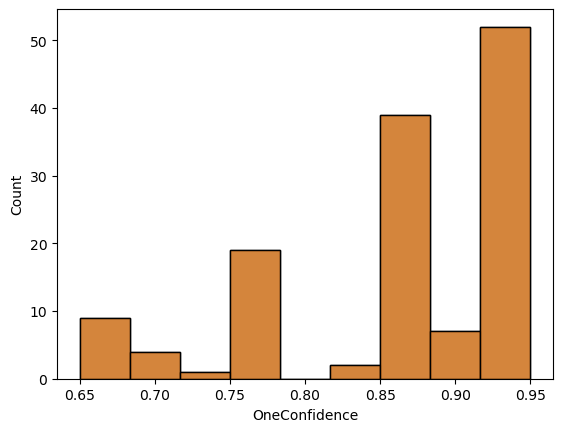

In [99]:
###
# Reloading LLM few-shot classification information
###
training_1 = pd.read_csv("C:/Users/rhals/Documents/obsidian/scratch/20250913 Resume/ML Project/interim_results/Approach1_training_processed.csv")
testing_1 = pd.read_csv("C:/Users/rhals/Documents/obsidian/scratch/20250913 Resume/ML Project/interim_results/Approach1_testing_processed.csv")
#encode y to a categorical numeric
#make new label encoder to preserve the 16 class names downstream, in case the LLM did not classify some medical specialties
le2 = LabelEncoder()

training_1['OneClassification'] = le2.fit_transform(training_1['OneClassification']) # map string labels to integer for algorithmic processing
testing_1['OneClassification'] = le2.fit_transform(testing_1['OneClassification']) # map string labels to integer for algorithmic processing

#inspecting confidences generated for fun, generally high and mean around .85, not shocking since few-shot examples all were around 0.8
sns.histplot(training_1['OneConfidence'])
sns.histplot(training_1['OneConfidence'])
# testing_1['OneConfidence'].mean()

In [91]:
###
# Create augmented training and testing data by adding few-shot LLM classifications (categorical) and uncertainty (quantitative)
###
df_training_3_augmented = pd.concat([df_training_3,training_1],axis=1)
df_testing_3_augmented = pd.concat([df_testing_3,testing_1],axis=1)
df_training_3_augmented['OneClassification'] = df_training_3_augmented['OneClassification'].astype('category')
df_testing_3_augmented['OneClassification'] = df_testing_3_augmented['OneClassification'].astype('category')

In [93]:
#base model to perform cross-validation on
model = XGBClassifier(
    num_class=len(le.classes_), 
    eval_metric='mlogloss',
    # use_label_encoder=False,
    max_depth=4,
    learning_rate=0.3,
    n_estimators=100,
    enable_categorical=True,
    random_state=42
)

In [94]:
param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy', verbose=1)
grid.fit(df_training_3_augmented, y_train_encoded)
print("Best parameters:", grid.best_params_)
#best found in cross-validation: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


In [96]:
###
# Implement xgboost Likert and fewshot LLM based model suggested by cross-validation
###
model_xgboost_likert_and_fewshot = XGBClassifier(
    num_class=len(le.classes_), 
    eval_metric='mlogloss',
    # use_label_encoder=False,
    max_depth=3,
    learning_rate=0.1,
    n_estimators=200,
    subsample=0.8,
    enable_categorical=True,
    random_state=42
)
model_xgboost_likert_and_fewshot.fit(df_training_3_augmented, y_train_encoded)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,True
,eval_metric,'mlogloss'


### Logistic Regression on Likert and few-shotted LLM

In [ ]:
model_logreg_augmented = LogisticRegression(max_iter=1000).fit(df_training_3_augmented, y_train_encoded)

### Develop performance analysis metrics

In [78]:
def get_results(model, relev_X, y_true, name_to_save_csv_to):
    # Predict class labels
    y_pred = model.predict(relev_X)
    # y_prob = model.predict_proba(relev_X) #if we want class probabilities, this is how we would get them
    get_results_already_have_pred(relev_X, y_pred, y_true, name_to_save_csv_to)
    
def get_results_already_have_pred(relev_X,y_pred,y_true, name_to_save_csv_to):
    print("\n Accuracy:", round(accuracy_score(y_true, y_pred),4))
    print("\n Classification Report:\n",
          classification_report(y_true, y_pred, target_names=le.classes_,zero_division=0))
    df_tmp = relev_X.copy()
    df_tmp['y_true'] = y_true
    df_tmp['y_pred'] = y_pred
    df_tmp.to_csv('C:/Users/rhals/Documents/obsidian/scratch/20250913 Resume/ML Project/results/'+name_to_save_csv_to + '.csv', sep=',',index=False)

# print("\n Predicted class labels:", y_pred[:5])
# print(" Actual class labels   :", y_train_encoded[:5])

# print("\n Predicted probabilities for first 5 samples:\n", y_prob[:5])

## Results for all models

### Training

In [104]:
###
# Few-shotted LLM
###
print("Few-shotted LLM")
get_results_already_have_pred(df_training_3,training_1['OneClassification'],y_train_encoded,"LLM_raw_training")
print("Logistic Regression on Likert Scale Data")
get_results(logreg, df_training_3, y_train_encoded, "logreg_training")
print("Logistic Regression on Likert and few-shotted LLM")
get_results(model_logreg_augmented, df_training_3_augmented, y_train_encoded, "logreg_training")
print("XGBoost Likert Only")
get_results(model_xgboost_onlylikert, df_training_3, y_train_encoded, "xgboost_training")
print("XGBoost Likert and few-shotted LLM")
get_results(model_xgboost_likert_and_fewshot, df_training_3_augmented, y_train_encoded, "xgboost_likert_and_fewshot_training")

Few-shotted LLM

 Accuracy: 0.4361

 Classification Report:
                                 precision    recall  f1-score   support

    Cardiovascular / Pulmonary       0.60      0.82      0.69        11
    Consult - History and Phy.       0.75      0.25      0.38        12
          ENT - Otolaryngology       0.75      1.00      0.86         3
              Gastroenterology       0.40      0.40      0.40         5
              General Medicine       0.57      0.44      0.50         9
                    Nephrology       1.00      0.33      0.50         3
                     Neurology       0.45      0.71      0.56         7
                  Neurosurgery       0.62      1.00      0.77         5
       Obstetrics / Gynecology       0.46      0.86      0.60         7
                  Office Notes       0.67      0.67      0.67         3
                 Ophthalmology       0.67      1.00      0.80         4
                    Orthopedic       0.56      1.00      0.71        10
  

### Testing

In [105]:
print("Few-shotted LLM")
get_results_already_have_pred(df_testing_3,testing_1['OneClassification'],y_test_encoded,"LLM_raw_testing")
print("Logistic Regression on Likert Scale Data")
get_results(logreg, df_testing_3, y_test_encoded, "logreg_testing")
print("Logistic Regression on Likert and few-shotted LLM")
get_results(model_logreg_augmented, df_testing_3_augmented, y_test_encoded, "logreg_testing")
print("XGBoost Likert Only")
get_results(model_xgboost_onlylikert, df_testing_3, y_test_encoded, "xgboost_testing")
print("XGBoost Likert and few-shotted LLM")
get_results(model_xgboost_likert_and_fewshot, df_testing_3_augmented, y_test_encoded, "xgboost_likert_and_fewshot_testing")

Few-shotted LLM

 Accuracy: 0.0889

 Classification Report:
                                 precision    recall  f1-score   support

    Cardiovascular / Pulmonary       0.67      1.00      0.80         4
    Consult - History and Phy.       0.00      0.00      0.00         4
          ENT - Otolaryngology       0.00      0.00      0.00         1
              Gastroenterology       0.00      0.00      0.00         1
              General Medicine       0.00      0.00      0.00         3
                    Nephrology       0.00      0.00      0.00         1
                     Neurology       0.00      0.00      0.00         2
                  Neurosurgery       0.00      0.00      0.00         1
       Obstetrics / Gynecology       0.00      0.00      0.00         3
                  Office Notes       0.00      0.00      0.00         1
                 Ophthalmology       0.00      0.00      0.00         1
                    Orthopedic       0.00      0.00      0.00         4
  

## Preparing for approach comparisons

In [35]:
y_prob

array([[1.78931572e-03, 2.88636074e-04, 4.88728518e-04, ...,
        3.53984971e-04, 8.53300333e-01, 1.23321906e-01],
       [9.74463532e-04, 4.79549381e-05, 1.73008040e-04, ...,
        1.47424929e-04, 9.91360843e-01, 2.47691700e-04],
       [1.00695519e-02, 8.73638511e-01, 1.21329364e-03, ...,
        1.39616011e-03, 5.71253884e-04, 3.43596854e-04],
       ...,
       [1.62516034e-03, 1.72692700e-03, 3.96916969e-03, ...,
        4.07361286e-03, 1.56845879e-02, 9.14823413e-01],
       [3.30918847e-04, 2.94321403e-03, 4.64164157e-04, ...,
        4.79336712e-04, 6.12501870e-04, 9.52074712e-04],
       [9.57748052e-05, 3.14738206e-03, 8.35491737e-05, ...,
        5.20229433e-03, 1.79349619e-04, 3.69606569e-05]],
      shape=(133, 16), dtype=float32)

In [62]:

from sklearn.metrics import classification_report

y_true = ["a","b","c"]
y_pred = ["c","a","c"]
print(classification_report(y_true,y_pred,zero_division=0))
# f1_score(y_true, y_pred, average=None)
#https://towardsdatascience.com/micro-macro-weighted-averages-of-f1-score-clearly-explained-b603420b292f/
#feature importance
#https://www.geeksforgeeks.org/machine-learning/xgboost-multiclass-classification/
#ROC-AUC how to create
#https://dzone.com/articles/xgboost-deep-dive

              precision    recall  f1-score   support

           a       0.00      0.00      0.00         1
           b       0.00      0.00      0.00         1
           c       0.50      1.00      0.67         1

    accuracy                           0.33         3
   macro avg       0.17      0.33      0.22         3
weighted avg       0.17      0.33      0.22         3

